# Looking into different death models

In [2]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt
import copy
import theano

%matplotlib inline

In [3]:
new_deaths = np.logspace(-3, 5, 100, base=np.e)
new_deaths[new_deaths < 1] = 0
new_deaths = np.ceil(new_deaths)

print(f"The true log growth rate is {8/100}")

The true log growth rate is 0.08


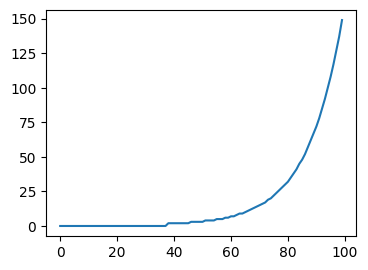

In [4]:
plt.figure(figsize=(4, 3), dpi=100)
plt.plot(new_deaths)

The model uses actual deaths to reverse calculated expected deaths, effectively. We can assume that expected deaths growths exponentially (assuming that we are at the start of teh pandemic)

In [ ]:
N_days = 100
new_deaths_logmodel = copy.deepcopy(new_deaths)
no_death_offset = 1e-3
new_deaths_logmodel += no_death_offset

with pm.Model() as logmodel:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    
    # lognorm output
    observed = pm.Normal("Observed", log_num_infected, sigma=0.3, observed=np.log(new_deaths_logmodel))

In [ ]:
pm.model_to_graphviz(logmodel)

In [ ]:
with logmodel:
    trace = pm.sample(500)

In [ ]:
def produce_CIs(data):
    means = np.mean(data, axis=0)
    li = np.percentile(data, 2.5, axis=0)
    ui = np.percentile(data, 97.5, axis=0)
    err = np.array([means - li, ui - means])
    return means, li, ui, err

In [ ]:
means, _, _, err = produce_CIs(trace["num_infected"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)

pm.traceplot(trace, "log_growth_rate")

# adding an offset

In [ ]:
N_days = 100
new_deaths_logmodel = copy.deepcopy(new_deaths)
no_death_offset = 1e-3
new_deaths_logmodel[new_deaths_logmodel < 1] = no_death_offset

with pm.Model() as logmodel:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    num_infected_offset = pm.Deterministic("num_infected_offset", pm.math.exp(log_num_infected) + no_death_offset)
    
    # lognorm output
    observed = pm.Normal("Observed", pm.math.log(num_infected_offset), sigma=0.3, observed=np.log(new_deaths_logmodel))
    
with logmodel:
    trace = pm.sample(500)

means, _, _, err = produce_CIs(trace["num_infected"])
means_offset, _, _, err_offset = produce_CIs(trace["num_infected_offset"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)
plt.errorbar(np.arange(new_deaths_logmodel.size), means_offset, yerr=err_offset)
plt.legend()

pm.traceplot(trace, "log_growth_rate")

In [ ]:
N_days = 100
new_deaths_masked_model = copy.deepcopy(new_deaths)
new_deaths_masked_model[new_deaths_masked_model < 1] = np.nan
new_deaths_masked_model = np.ma.masked_invalid(new_deaths_masked_model.astype(theano.config.floatX))

with pm.Model() as masked_model:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    
    # lognorm output
    observed = pm.Normal("Observed", pm.math.log(num_infected), sigma=0.3, observed=np.log(new_deaths_masked_model))
    
with masked_model:
    trace = pm.sample(500)

means, _, _, err = produce_CIs(trace["num_infected"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)
plt.legend()

pm.traceplot(trace, "log_growth_rate")

Of the methods we have tried, this is the one which has worked best .... 

In [ ]:
N_days = 100
new_deaths_negative_binomial = copy.deepcopy(new_deaths)


with pm.Model() as nb_model:
    log_growth_rate = T.ones(N_days) * pm.Normal("log_growth_rate", 0, 0.5)
    log_n0 = pm.Normal("log_n0", -3, 1)
    log_num_infected = pm.Deterministic("log_num_infected", log_n0 + log_growth_rate.cumsum())
    num_infected = pm.Deterministic("num_infected", pm.math.exp(log_num_infected))
    
    # lognorm output
    observed = pm.NegativeBinomial("Observed", mu=num_infected, alpha=0.3, observed=new_deaths_negative_binomial)
    
with nb_model:
    trace = pm.sample(500)

means, _, _, err = produce_CIs(trace["num_infected"])

plt.figure(figsize=(8, 3), dpi=100)
plt.semilogy(new_deaths_logmodel)
plt.semilogy(new_deaths)
plt.errorbar(np.arange(new_deaths_logmodel.size), means, yerr=err)
plt.legend()

pm.traceplot(trace, "log_growth_rate")

This one also worked well.

target mean: 10 var: 20.0
pmf mean: 10.000000000000004 pmf var: 20.000000000000014


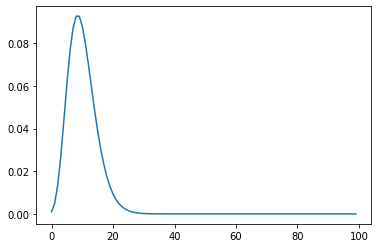

In [33]:
target_mean = 10
Phi = 10
target_var = 10 + ((10 ** 2) / (Phi))

print(f"target mean: {target_mean} var: {target_var}")

x_vals = np.arange(100)
d = pm.NegativeBinomial.dist(mu=target_mean, alpha=Phi)
pmf = np.exp(d.logp(x_vals).eval())
plt.plot(x_vals, pmf)

pmf_mean = np.sum([k * pmf[k] for k in range(len(x_vals))])
pmf_var = np.sum([(k**2) * pmf[k] for k in range(len(x_vals))]) - pmf_mean**2
print(f"pmf mean: {pmf_mean} pmf var: {pmf_var}")

In [30]:
pmf**2

array([7.71604938e-04, 2.14334705e-03, 3.34897977e-03, 4.13454292e-03,
       4.48626619e-03, 4.48626619e-03, 4.24049081e-03, 3.84625016e-03,
       3.38049331e-03, 2.89822814e-03, 2.43531671e-03, 2.01265843e-03,
       1.64033215e-03, 1.32110907e-03, 1.05318006e-03, 8.32142268e-04,
       6.52368477e-04, 5.07899334e-04, 3.92986239e-04, 3.02390150e-04,
       2.31517458e-04, 1.76452585e-04, 1.33929376e-04, 1.01269849e-04,
       7.63089022e-05, 5.73164643e-05, 4.29237575e-05, 3.20570662e-05,
       2.38803790e-05, 1.77470118e-05, 1.31596283e-05, 9.73772936e-06,
       7.19156038e-06, 5.30140024e-06, 3.90127312e-06, 2.86624148e-06,
       2.10256161e-06, 1.54010377e-06, 1.12654751e-06, 8.22958224e-07,
       6.00430891e-07, 4.37553743e-07, 3.18498390e-07, 2.31586474e-07,
       1.68217190e-07, 1.22067069e-07, 8.84944589e-08, 6.40973899e-08,
       4.63860656e-08, 3.35407596e-08, 2.42331988e-08, 1.74950259e-08,
       1.26210983e-08, 9.09851336e-09, 6.55459412e-09, 4.71882626e-09,
      